# Unsupervised Learning: Clustering

In classification (supervised), we try to find boundaries/rules to separate points according to pre-determined labels.

In clustering, the algorithm chooses the labels.  Goal is to choose labels so that similar rows get labeled the same.

Today: K-Means Clustering

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import datasets

In [2]:
x, y = datasets.make_blobs(n_samples=100, centers=3, cluster_std=1.2, random_state=3)
df = pd.DataFrame(x, columns=["x0", "x1"])
df.head()

,x0,x1
0,8.370099,7.747045
1,-2.701740,0.395336
2,-3.204128,-0.407438
3,-3.132762,-1.335692
4,7.152737,6.069995


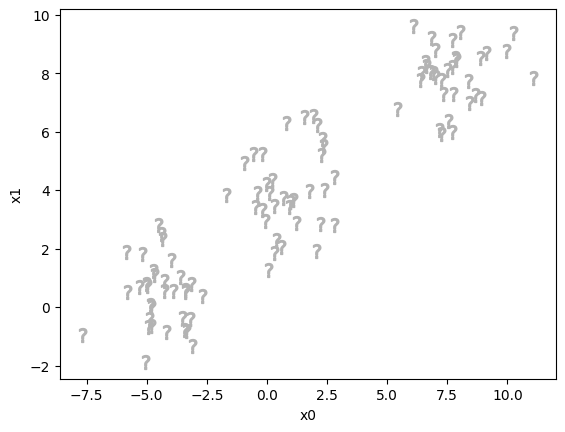

In [3]:
# x0 => x-axis
# x1 => y-axis
# cluster => marker type
def km_scatter(df, **kwargs):
    ax = kwargs.pop("ax", None)
    if not "label" in df.columns:
        return df.plot.scatter(x="x0", y="x1", marker="$?$", ax=ax, **kwargs)

    for marker in set(df["label"]):
        sub_df = df[df["label"] == marker]
        ax = sub_df.plot.scatter(x="x0", y="x1", marker=marker, ax=ax, **kwargs)
    return ax

ax = km_scatter(df, s=100, c="0.7")

# Hard Problem

Finding the best answer.

# Easier Problem

Taking a bad answer and make it a little better.  Then repeat!

<AxesSubplot:xlabel='x0', ylabel='x1'>

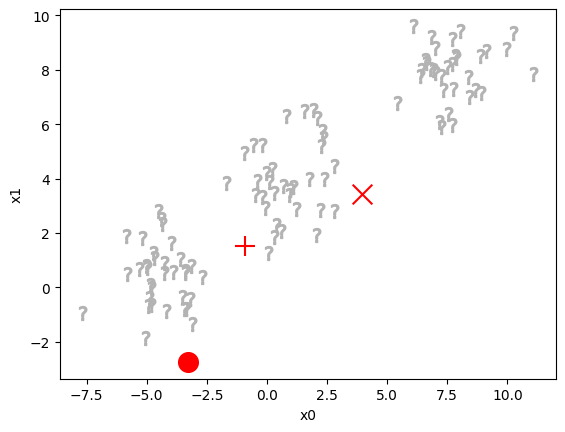

In [46]:
clusters = np.random.uniform(-5, 5, size=(3,2))
clusters = pd.DataFrame(clusters, columns=["x0", "x1"])
clusters["label"] = ["o", "+", "x"]

ax = km_scatter(df, s=100, c="0.7")
km_scatter(clusters, s=200, c="red", ax=ax)

In [47]:
clusters

,x0,x1,label
0,-3.296947,-2.739279,o
1,-0.919733,1.511903,+
2,3.974110,3.425267,x


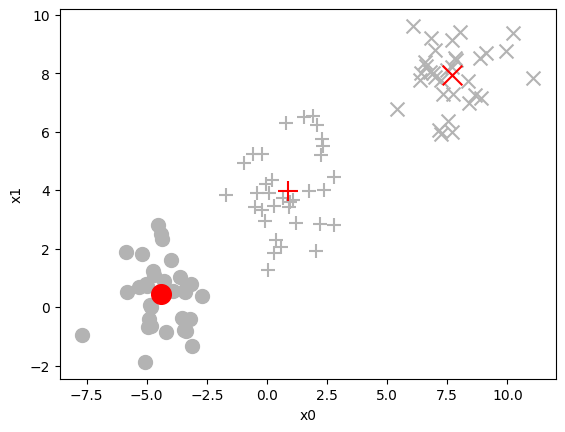

In [48]:
class KM:
    def __init__(self, df, clusters):
        self.df = df.copy()
        self.clusters = clusters.copy()
        self.labels = clusters["label"].values
        
    def assign_points(self):
        for center in self.clusters.itertuples():
            x0_diff = self.df["x0"] - center.x0
            x1_diff = self.df["x1"] - center.x1
            distance = (x0_diff ** 2 + x1_diff ** 2) ** 0.5
            self.df[center.label] = distance
        self.df["label"] = self.labels[self.df[self.labels].values.argmin(axis=1)]
    
    def update_centers(self):
        for center in self.clusters.itertuples():
            subset_df = self.df[self.df["label"] == center.label]
            if len(subset_df) > 0:
                x0 = subset_df["x0"].mean()
                x1 = subset_df["x1"].mean()
                self.clusters.at[center.Index, "x0"] = x0
                self.clusters.at[center.Index, "x1"] = x1
    
    def plot(self):
        ax = km_scatter(self.df, color="0.7", s=100)
        km_scatter(self.clusters, ax=ax, color="r", s=200)
        
km = KM(df, clusters)

for epoch in range(10):
    km.assign_points()
    km.update_centers()

km.plot()

# KMeans in sklearn

In [49]:
from sklearn.cluster import KMeans
# km (our version from scratch) and km2 (the one from sklearn)
km2 = KMeans(3)

In [50]:
# 1. fit: figure out what the centroids are
km2.fit(df)
km2.cluster_centers_ # each row is a centroid (columns are x0 and x1)

array([[-4.41347291,  0.43410278],
       [ 7.69751168,  7.9241129 ],
       [ 0.85985598,  3.98556415]])

In [51]:
km.clusters

,x0,x1,label
0,-4.413473,0.434103,o
1,0.859856,3.985564,+
2,7.697512,7.924113,x


In [54]:
# 2. transform: give me the distance from each point to each centroid
km2.transform(df.head())

array([[14.72748598,  0.69550479,  8.39955315],
       [ 1.71217188, 12.83849367,  5.057144  ],
       [ 1.47333179, 13.72080475,  5.984516  ],
       [ 2.18458064, 14.24916908,  6.65257594],
       [12.86625407,  1.93249405,  6.62911793]])

In [57]:
km.df[["o", "+", "x"]]

,o,+,x
0,14.727486,8.399553,0.695505
1,1.712172,5.057144,12.838494
2,1.473332,5.984516,13.720805
3,2.184581,6.652576,14.249169
4,12.866254,6.629118,1.932494
...,...,...,...
95,0.704917,6.253922,14.141920
96,1.006656,5.502204,13.351683
97,6.073362,0.304807,8.168962
98,13.959504,7.638137,0.632635


In [58]:
# 3. predict: put them in categories (but remember there's not a "correct" answer)
km2.predict(df)

array([1, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 1, 1, 2, 0, 1, 1, 0, 0, 2, 2,
       0, 2, 0, 1, 1, 2, 0, 1, 2, 2, 1, 0, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2,
       0, 0, 2, 0, 1, 0, 2, 1, 0, 1, 0, 1, 0, 1, 2, 2, 2, 0, 2, 2, 0, 2,
       1, 0, 2, 0, 0, 1, 2, 0, 2, 2, 0, 2, 1, 0, 2, 2, 2, 2, 1, 2, 0, 1,
       2, 1, 2, 1, 1, 0, 1, 0, 0, 2, 1, 1], dtype=int32)

In [62]:
km.df["label"]

0     x
1     o
2     o
3     o
4     x
     ..
95    o
96    o
97    +
98    x
99    x
Name: label, Length: 100, dtype: object

In [63]:
# shorthand: fit on df followed by predict on df
km2.fit_predict(df)

array([1, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 1, 1, 2, 0, 1, 1, 0, 0, 2, 2,
       0, 2, 0, 1, 1, 2, 0, 1, 2, 2, 1, 0, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2,
       0, 0, 2, 0, 1, 0, 2, 1, 0, 1, 0, 1, 0, 1, 2, 2, 2, 0, 2, 2, 0, 2,
       1, 0, 2, 0, 0, 1, 2, 0, 2, 2, 0, 2, 1, 0, 2, 2, 2, 2, 1, 2, 0, 1,
       2, 1, 2, 1, 1, 0, 1, 0, 0, 2, 1, 1], dtype=int32)

# How many clusters?

# KMeans as Preprocessing

Sometimes we'll use an unsupervised learning technique (like k-means) to pre-process data, creating better inputs for a supervised learning technique (like logistic regression)

In [9]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [10]:
def make_data():
    x, y = datasets.make_blobs(n_samples=250, centers=5, random_state=5)
    xcols = ["x0", "x1"]
    df1 = pd.DataFrame(x, columns=xcols)
    df1["y"] = y > 0

    df2 = pd.DataFrame(np.random.uniform(-10, 10, size=(250, 2)), columns=["x0", "x1"])
    df2["y"] = False

    return pd.concat((df1, df2))

train, test = train_test_split(make_data())

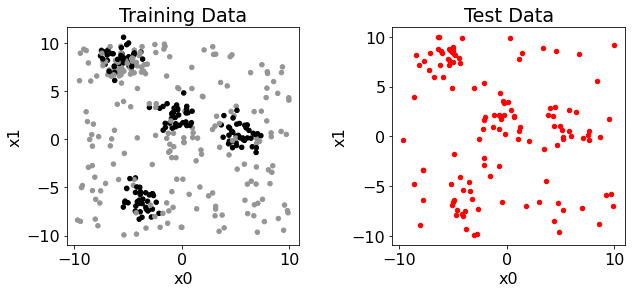

In [11]:
plt.rcParams["font.size"] = 16
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
train.plot.scatter(x="x0", y="x1", c=train["y"], vmin=-1, ax=ax[0])
test.plot.scatter(x="x0", y="x1", c="red", ax=ax[1])
ax[0].set_title("Training Data")
ax[1].set_title("Test Data")
plt.subplots_adjust(wspace=0.4)

# StandardScaler with KMeans

<AxesSubplot:xlabel='0', ylabel='1'>

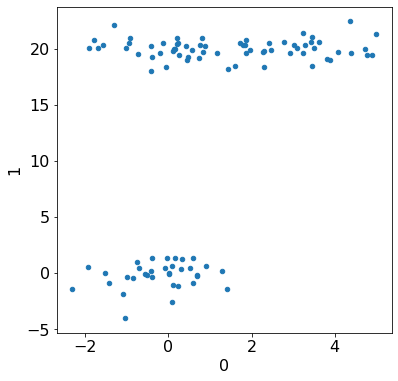

In [12]:
x = datasets.make_blobs(centers=np.array([(0,0), (0,20), (3,20)]))[0]
df = pd.DataFrame(x)
df.plot.scatter(x=0, y=1, figsize=(6,6))